## Machine Learning for Blood Disease Chapter Classification

### Problem Context

One of the areas of focus is the development of a model for classifying **Chapter of blood diseases**. This approach has several key features:

1. **More generalizable models**:
   - Works at the level of groups of related diseases
   - Resistant to rare specific diagnoses

2. **Clinical practice**:
   - Corresponds to the logic of differential diagnosis
   - Useful in the early stages of examination

3. **Data**:
   - We use a hierarchical structure of diagnoses (CD90-D47, etc.)


### Technical Implementation

**Features of the approach**:
- Multi-class classification 
- Metrics evaluate:
- Accuracy at the family level

### Import Libraries

In [44]:
# Standard library imports
import os
import sys

# Third-party scientific computing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Scikit-learn components
from sklearn import (
    decomposition,
    ensemble,
    feature_selection,
    impute,
    linear_model,
    manifold,
    metrics,
    model_selection,
    neighbors,
    pipeline,
    preprocessing,
)

# Scikit-learn specific imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import (
    KNNImputer,
    SimpleImputer,
)
from sklearn.linear_model import (
    ElasticNet,
    LinearRegression,
    LogisticRegression,
    Ridge,
)
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    roc_auc_score,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    ShuffleSplit,
    StratifiedKFold,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
)

# Other ML libraries
import lightgbm as lgb
import optuna
import shap
from umap import UMAP

# Synthetic data (if needed)
from sklearn.datasets import make_classification

## Loading Data

In [45]:
parent_dir = os.getcwd()
dir = parent_dir
os.chdir(dir)

In [46]:
df = pd.read_excel("/Users/valeria/Desktop/Hackaton/data_finish.xlsx")

- Add heathy patients

In [47]:
df.loc[df["диагноз клинический"] == "healthy", "grouped_diagnosis"] = "healthy"

## Transform

- Creation and application of LabelEncoder to convert categorical labels into numerical ones

#### Formation of a feature matrix (X) by removing:
 - the target column
 - the original column with diagnoses (to avoid data leakage)
 - the client ID (non-informative feature)

In [ ]:
target_column = "grouped_diagnosis"

le = LabelEncoder()
y = le.fit_transform(df[target_column])
X = df.drop(columns=[target_column, "диагноз клинический", "client_id", "Unnamed: 0"])

In [49]:
df[df["grouped_diagnosis"] == "healthy"]

,Unnamed: 0,client_id,age,диагноз клинический,grouped_diagnosis,Базофилы[00029],Базофилы[00030],Гематокрит[00003],Гемоглобин[00001],Лейкоциты[00010],...,Общий белок[1.11.1.1],Холестерин[1.11.1.7],gender,Анизоцитоз[ЛФ_Анизоцитоз]_+,Анизоцитоз[ЛФ_Анизоцитоз]_++,Анизоцитоз[ЛФ_Анизоцитоз]_+++,Анизоцитоз[ЛФ_Анизоцитоз]_-,Пойкилоцитоз[ЛФ_Пойкилоцитоз]_+,Пойкилоцитоз[ЛФ_Пойкилоцитоз]_++,Пойкилоцитоз[ЛФ_Пойкилоцитоз]_+++
451,451,229587,17.0,healthy,healthy,0.02,0.3,0.445,157.0,6.38,...,NaN,NaN,1,0,0,0,0,0,0,0
2668,2668,237034,51.0,healthy,healthy,0.05,0.6,0.439,157.0,8.42,...,NaN,NaN,1,0,0,0,0,0,0,0
4044,4044,241997,26.0,healthy,healthy,0.01,0.2,0.431,157.0,5.91,...,NaN,NaN,1,0,0,0,0,0,0,0
4461,4461,243926,33.0,healthy,healthy,0.04,0.6,0.461,157.0,6.91,...,NaN,NaN,1,0,0,0,0,0,0,0
4686,4686,242754,36.0,healthy,healthy,0.04,0.5,0.394,140.0,7.83,...,73.1,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29607,29607,404949,18.0,healthy,healthy,0.04,0.6,0.440,150.0,7.03,...,73.7,3.18,1,0,0,0,0,0,0,0
29637,29637,440485,29.0,healthy,healthy,0.07,0.9,0.400,136.0,8.08,...,72.1,NaN,0,0,0,0,0,0,0,0
30017,30017,444014,29.0,healthy,healthy,0.04,0.8,0.410,141.0,4.97,...,75.0,4.39,1,0,0,0,0,0,0,0
30031,30031,422111,52.0,healthy,healthy,0.05,0.7,0.390,136.0,7.46,...,75.7,NaN,0,0,0,0,0,0,0,0


## Dataset Balancing for Multi-Class Classification (19 classes)
 
**1. Creates a balanced sample**  
- Exactly **1,000 examples** for each class  

**2. For “poor” classes (<1,000 examples)**  
- Uses **“cloning”** of existing data (duplicates)  

**3. The output is:**  
- `X_balanced` — features without bias  
- `y_balanced`

In [59]:
np.random.seed(42)

list_of_X = []
for i in range(19):
    if pd.Series(y).value_counts().loc[i] > 1000:
        indices = np.random.choice(np.where(y == i)[0], size=1000, replace=False)
    else:
        indices = np.random.choice(np.where(y == i)[0], size=1000, replace=True)
    list_of_X.append(X.loc[indices])


X_balanced = pd.concat(list_of_X)

y_balanced = []
for num in range(19):  # 1 to 19
    y_balanced += [num] * 1000

## Split 

- **Stratify**— maintains class balance in each set
- **Val from train** — to avoid "leakage" at the test data

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced.values, y_balanced, stratify=y_balanced, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

## Choosing Models  

When analyzing various approaches to handling missing data, we compared:

### 🔍 Approaches Analyzed

### 1️⃣ Models Requiring Complete Data

- `Logistic Regression softmax`
- `Logistic Regression OvR`
- `Random Forest`
- `Gradient Boosting`
- `KNN`

**Key Limitations:**

- Require preliminary filling of gaps 
- Risk of introducing bias due to artificial filling.
- Increased computational costs during preprocessing.

### 2️⃣ Models with Native Missing Value Support

- `XGBoost`
- `LightGBM`
- `CatBoost`

**Special Capabilities:**

- Automatically handle missing values when building trees, without the need for filling.
- Optimally use missing values as an informative signal (for example, by directing them to separate tree branches).
- Effective for data with a large number of missing values, as they preserve the original distribution.

Why is the second approach preferable?

| Criterion | Complete-Data Models | Native-Support Models |
|-----------|----------------------|-----------------------|
| **Information Preservation** | ❌ Distorts through imputation | ✅ Maintains NA patterns |
| **Computational Efficiency** | ❌ Extra preprocessing step | ✅ Direct modeling |
| **Bias Risk** | ❌ High (imputation artifacts) | ✅ Low (uses raw data) |
| **Interpretability** | ❌ Hard to trace NA impact | ✅ Clear NA handling |

**Key Advantages:**
- Missing values may carry semantic meaning
- More robust to data imperfections
- Typically better performance with sparse data



💡 For our data, where missing values are numerous and potentially informative, models with built-in support for missing values (XGBoost, LightGBM, CatBoost) are the optimal choice. They provide higher accuracy and interpretability of results without additional data transformations.


# Complete-Data Models

### Methods for handling missing values


#### 1. Imputation using the mean value
**Class:** `SimpleImputer(strategy=‘mean’)`  
**How it works:**  
Replaces missing values (NaN) with the arithmetic mean for the corresponding data column.

**Features:**
- ✅ Easy to implement
- ✅ Fast execution
- ❌ Sensitive to outliers
- ❌ Does not take into account the relationships between features

---

#### 2. KNN imputation
**Class:** `KNNImputer`  
**How it works:**  
Fills in missing values based on the values of the 5 nearest neighbors, using equal weights for all neighbors.

**Features:**
- Takes into account the relationships between variables

---

#### 3. Median imputation
**Class:** `SimpleImputer(strategy=‘median’)`  
**How it works:**  
Replaces missing values with the median of the corresponding column.

**Advantages:**
- Robust to outliers
- Suitable for data with asymmetric distribution
- Preserves the central tendency in skewed distributions

---

####  4. Iterative imputation
**Class:** `IterativeImputer`  
**Algorithm:**  
1. Temporary replacement of missing values with initial values
2. Sequential modeling of each feature as a function of other features
3. Multiple refinement of values (up to 10 iterations)

**Key features:**
- The most accurate method of those presented
- Takes into account complex nonlinear dependencies
- Significant computational costs

In [52]:
# imputation

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# mean
imputer_mean = SimpleImputer(strategy="mean")
X_train_imputed_mean = imputer_mean.fit_transform(X_train)
X_val_imputed_mean = imputer_mean.transform(X_val)


# neighbors
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# median
imputer_median = SimpleImputer(strategy="median")
X_train_imputed_median = imputer_median.fit_transform(X_train)
X_val_imputed_median = imputer_median.transform(X_val)

# interative
imputer_iterative = IterativeImputer(max_iter=10, random_state=42)
X_train_imputed_iterative = imputer_iterative.fit_transform(X_train)
X_val_imputed_iterative = imputer_iterative.transform(X_val)

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Models

We USE:

#### Comparison of classification models

##### 1. Logistic regression (One-vs-Rest)
**Initialization:**  
`LogisticRegression(multi_class=‘ovr’, solver=‘liblinear’, max_iter=1000)`

**Features:**
- `multi_class=‘ovr’` - binary classification for each class
- `solver=‘liblinear’` - effective for small datasets
- Suitable for:
  - Binary and multi-class tasks
  - Linearly separable data
  - Interpretability of results

---

##### 2. Logistic regression (Softmax)
**Initialization:**  
`LogisticRegression(multi_class=‘multinomial’, solver=‘lbfgs’, max_iter=1000)`

**Features:**
- `multi_class=‘multinomial’` - true multi-class classification
- `solver=‘lbfgs’` - suitable for medium-scale datasets
- Advantages:
  - More accurate probability estimation
  - Takes into account the relationships between classes

---

##### 3. Random Forest
**Initialization:**  
`RandomForestClassifier(random_state=42)`

**Key properties:**
- Ensemble of decision trees
- Default parameters:
  - `n_estimators=100`
  - `max_depth=None`
- Strengths:
  - Resistance to overfitting
  - Works with nonlinear dependencies

---


##### 4. Gradient Boosting
**Initialization:**  
`GradientBoostingClassifier(random_state=42)`

**Implementation features:**
- Sequential tree construction
- Default parameters:
- `learning_rate=0.1`
  - `n_estimators=100`
- Advantages (maybe):
  - High accuracy
  - Sensitivity to outliers

---

##### 5. k-nearest neighbors method
**Initialization:**  
`KNeighborsClassifier(n_neighbors=5)`

**Characteristics:**
- Nonparametric method
- Key parameter:
  - `n_neighbors=5` - number of neighbors considered
- Features:
  - Requires data normalization
  - Sensitive to dimensionality
  - Preserves data distribution

---



In [53]:
models = {
    "LogisticRegression (OvR)": LogisticRegression(
        multi_class="ovr", solver="liblinear", max_iter=1000
    ),
    "LogisticRegression (Softmax)": LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=1000
    ),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5),
}

In [54]:
data_without_na = {
    "mean": (X_train_imputed_mean, X_val_imputed_mean),
    "knn": (X_train_imputed, X_val_imputed),
    "median": (X_train_imputed_median, X_val_imputed_median),
    "iter": (X_train_imputed_iterative, X_val_imputed_iterative),
}


val_results = {}
for name, model in models.items():
    val_results[name] = {}
    for name_imput, (X_train, X_val) in data_without_na.items():

        # model training
        scaler = StandardScaler()
        X_train_scal = scaler.fit_transform(X_train)
        X_val_scal = scaler.transform(X_val)

        model.fit(X_train_scal, y_train)
        y_pred = model.predict(X_val_scal)
        y_proba = (
            model.predict_proba(X_val_scal) if hasattr(model, "predict_proba") else None
        )

        val_results[name][name_imput] = {
            "Accuracy": accuracy_score(y_val, y_pred),
            "F1-micro": f1_score(y_val, y_pred, average="micro"),
            "F1-macro": f1_score(y_val, y_pred, average="macro"),
            "Precision-micro": precision_score(y_val, y_pred, average="micro"),
            "Precision-macro": precision_score(y_val, y_pred, average="macro"),
            "Recall-micro": recall_score(y_val, y_pred, average="micro"),
            "Recall-macro": recall_score(y_val, y_pred, average="macro"),
            "AUC-ROC": roc_auc_score(y_val, y_proba, multi_class="ovr"),
        }

# Convert validation results to DataFrame
val_results_df = pd.DataFrame(val_results).T
print("\n=== Validation Set Performance ===")
print(val_results_df)

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/valeria/miniconda3/envs/bioINF


=== Validation Set Performance ===
                                                                           mean  \
LogisticRegression (OvR)      {'Accuracy': 0.42664473684210524, 'F1-micro': ...   
LogisticRegression (Softmax)  {'Accuracy': 0.42828947368421055, 'F1-micro': ...   
RandomForest                  {'Accuracy': 0.6723684210526316, 'F1-micro': 0...   
GradientBoosting              {'Accuracy': 0.5868421052631579, 'F1-micro': 0...   
KNeighbors                    {'Accuracy': 0.4463815789473684, 'F1-micro': 0...   

                                                                            knn  \
LogisticRegression (OvR)      {'Accuracy': 0.4108552631578947, 'F1-micro': 0...   
LogisticRegression (Softmax)  {'Accuracy': 0.41480263157894737, 'F1-micro': ...   
RandomForest                  {'Accuracy': 0.6532894736842105, 'F1-micro': 0...   
GradientBoosting              {'Accuracy': 0.5634868421052631, 'F1-micro': 0...   
KNeighbors                    {'Accuracy': 0.43848

## Metrics

In [55]:
flat_data = []
for model_name, row in val_results_df.iterrows():
    for impute_method, metrics_dict in row.items():
        for metric_name, metric_value in metrics_dict.items():
            flat_data.append(
                {
                    "Model": model_name,
                    "Imputation": impute_method,
                    "Metric": metric_name,
                    "Value": metric_value,
                }
            )

# DataFrame
result_df = pd.DataFrame(flat_data)

df_sorted = result_df.sort_values("Metric", ascending=False)

wide_df = result_df.pivot_table(
    index=["Model", "Imputation"], columns="Metric", values="Value"
)


styled_df = (
    wide_df.style.format("{:.3f}")
    .set_properties(**{"text-align": "center"})
    .background_gradient(subset=["Accuracy"], cmap="Purples")
    .set_caption("Model feeling NA Results")
)


display(styled_df)

# Analysis of the results of basic models

## Features of our data
- The dataset demonstrates a complex **nonlinear nature** with several key characteristics:

1. **High heterogeneity**:
- Features are of different nature (numerical, categorical)
   - Multi-scale distributions of values
   - Non-obvious interactions between variables

2. **Complex dependencies**:
   - Lack of linear separability of classes
   - Multi-layered patterns of interrelationships

3. **Imputation problems**:
   - Traditional methods of filling in gaps (mean/median) distort the original distributions
   - Loss of information during preprocessing


# Analysis of Random Forest and Gradient Boosting results

## Key observation
Both ensemble methods showed **relatively good results**, but with an important caveat:

⚠️ *All metrics were obtained from data with artificially filled gaps*, which could:
- Distort the natural relationships between features
- Add noise to the original distributions
- Reduce the real potential of the models

## Comparative analysis

| Aspect                      | Random Forest                  | Gradient Boosting               |
|-----------------------------|--------------------------------|---------------------------------|
| **Handling missing values** | Requires complete data         | Requires complete data          |
| **Performance with imputation** | Good (baseline level)      | Good (baseline level)           |
| **Native missing value support** | ❌ Not supported         | ❌ Not supported                |
| **Optimal usage scenario**  | Pre-imputed data              | Pre-imputed data                |
| **True potential**          | Underestimated due to imputation | Underestimated due to imputation |

# Native-Support Models (Boosting)


- We selected three main algorithms to solve the task: **CatBoost, LightGBM, and XGBoost.**

## Key data processing mechanisms

| Feature                        | CatBoost                                   | LightGBM                                  | XGBoost                                  |
|--------------------------------|-------------------------------------------|------------------------------------------|------------------------------------------|
| **Missing value handling**      | Automatically finds optimal tree direction for NaN | Treats missing as separate value (left/right subtree) | Pre-fills missing=0 with optimization |
| **Categorical features**       | Ordered Target Encoding (no data leakage) | GOSS method for categories               | Requires one-hot encoding               |
| **Regularization**             | Symmetric trees + L2 + Bayesian           | GOSS + EFB                               | L1/L2 + alpha/gamma                     |
| **Class imbalance handling**   | Auto class weights + Prior                | balance_beta + scale_pos_weight          | scale_pos_weight                        |
| **Boosting mechanism**         | Ordered boosting with permutations        | Gradient-based One-Side Sampling         | Exact + approximate methods             |

## 1. XGBoost (eXtreme Gradient Boosting)

#### Advantages:
- ✅ High accuracy – strong regularization (L1/L2), resistance to overfitting.
- ✅ Flexibility – support for custom loss functions and metrics.
- ✅ Interpretability – built-in feature importance analysis methods (gain, cover).
- ✅ GPU support – accelerated training on large datasets.

#### Disadvantages:
- ❌ Slower than LightGBM – due to level-wise tree growth.
- ❌ Requires preprocessing of categorical features (one-hot encoding, label encoding).

## 📊 Basic model launch with default parameters


### Model diagnostics
- Checking **performance** without optimization
- Identifying obvious problems:
 - Extremely low metrics → errors in data
- Allows you to assess the real benefits of subsequent configuration

### Check correctness:
  - Data intake
  - Feature encoding

In [61]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models_boosting = {
    "XGBoost": XGBClassifier(
        random_state=42, eval_metric="mlogloss", use_label_encoder=False
    ),
    "LightGBM": LGBMClassifier(random_state=42),
}

In [62]:
boost_results = {}
for name, model in models_boosting.items():
    boost_results[name] = {}

    # Обучение модели
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val) if hasattr(model, "predict_proba") else None

    boost_results[name] = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "F1-micro": f1_score(y_val, y_pred, average="micro"),
        "F1-macro": f1_score(y_val, y_pred, average="macro"),
        "Precision-micro": precision_score(y_val, y_pred, average="micro"),
        "Precision-macro": precision_score(y_val, y_pred, average="macro"),
        "Recall-micro": recall_score(y_val, y_pred, average="micro"),
        "Recall-macro": recall_score(y_val, y_pred, average="macro"),
        "AUC-ROC": roc_auc_score(y_val, y_proba, multi_class="ovr"),
    }

# Convert validation results to DataFrame
boost_results_df = pd.DataFrame(boost_results).T
print("\n=== Validation Set Performance ===")
print(boost_results_df)

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [14:40:08] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Validation Set Performance ===
          Accuracy  F1-micro  F1-macro  Precision-micro  Precision-macro  \
XGBoost   0.689474  0.689474  0.683639         0.689474         0.681344   
LightGBM  0.687829  0.687829  0.682755         0.687829         0.680983   

          Recall-micro  Recall-macro   AUC-ROC  
XGBoost       0.689474      0.689474  0.950943  
LightGBM      0.687829      0.687829  0.951892  


/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


- The metrics are not bad. Let's start selecting parameters.

## Optimization for XGBoosting 

- Optimization using optuna library 

#### How does Optuna select parameters?

| Optimization Stage          | Description                                                                 | Key Methods/Features                                                                 |
|----------------------------|-----------------------------------------------------------------------------|-------------------------------------------------------------------------------------|
| **Parameter Space Definition** | Specifies value ranges for each model parameter                            | - `suggest_float()`: Continuous values<br>- `suggest_int()`: Integer values<br>- `suggest_categorical()`: Discrete choices |
| **Parameter Assessment**    | Evaluates model performance with different parameter combinations           | - Tracks metrics (accuracy, AUC-ROC)<br>- Stores all trial results<br>- Supports custom metrics |
| **Adaptive Optimization**  | Uses past trial results to guide future parameter selection                | - Bayesian optimization (TPE)<br>- Parameter correlation analysis<br>- Intelligent sampling |
| **Trial Management**       | Stops unpromising trials early to save computation resources               | - Automatic pruning<br>- Early stopping integration<br>- Parallel trial execution |



In [63]:
def objective(trial) -> float:
    """Objective function for hyperparameter optimization using Optuna.
    This function defines the hyperparameters to optimize and evaluates the model's performance
    using the F1 score on the validation set."""

    # Define hyperparameters to optimize
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
    }

    # Initialize and train model
    model_opt = XGBClassifier(**params, random_state=42)

    model_opt.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model_opt.predict(X_val)
    f1 = f1_score(y_val, y_pred, average="macro")

    return f1


# Create study and optimize
study = optuna.create_study(direction="maximize")  #
study.optimize(objective, n_trials=50)  # Adjust n_trials and timeout as needed

# Print results
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-10 14:40:16,710] A new study created in memory with name: no-name-3ea6d5cf-dcb3-40ff-b260-04937d397ace
[I 2025-08-10 14:40:32,468] Trial 0 finished with value: 0.6193172638851667 and parameters: {'n_estimators': 216, 'learning_rate': 0.009161390029161116, 'max_depth': 9, 'subsample': 0.7309012532119814, 'colsample_bytree': 0.9025704080157738, 'gamma': 0.6757503984259733, 'reg_alpha': 0.15151947379144604, 'reg_lambda': 3.776876164405282}. Best is trial 0 with value: 0.6193172638851667.
[I 2025-08-10 14:40:37,949] Trial 1 finished with value: 0.45675341990177915 and parameters: {'n_estimators': 332, 'learning_rate': 0.0018047036294924817, 'max_depth': 4, 'subsample': 0.5954590825619739, 'colsample_bytree': 0.578784541865973, 'gamma': 4.064768643483959, 'reg_alpha': 2.2201070647545142, 'reg_lambda': 1.8077052986703679}. Best is trial 0 with value: 0.6193172638851667.
[I 2025-08-10 14:41:04,117] Trial 2 finished with value: 0.568363048271134 and parameters: {'n_estimators': 430,

Best trial:
  Value: 0.6836994457803077
  Params: 
    n_estimators: 717
    learning_rate: 0.013992303482744306
    max_depth: 8
    subsample: 0.679044411044376
    colsample_bytree: 0.9886355201328905
    gamma: 0.08513473859846876
    reg_alpha: 0.729931992583273
    reg_lambda: 3.329099334468904


### 🏆 Best Hyperparameters Trial for XGBoosting

| Metric            | Value                  |
|-------------------|------------------------|
| **Best F1-Score** | `0.684`              |

### ⚙️ Optimized Parameters

| Parameter           | Optimal Value         |
|---------------------|----------------------|
| `n_estimators`      | 717                  |
| `learning_rate`     | 0.014            |
| `max_depth`         | 8                  |
| `subsample`         | 0.679               |
| `colsample_bytree`  | 0.988            |
| `gamma`             | 0.085             |
| `reg_alpha`         | 0.73           |
| `reg_lambda`        | 3.32          |

### Training with best_params (XGBoost)

In [64]:
best_params = study.best_params


XBoost_best_model = {}

# Model Training with best parameters
XBoost = XGBClassifier(**best_params, random_state=42)
XBoost.fit(np.array(X_train), np.array(y_train))
y_pred_XBoost = XBoost.predict(X_val)
y_proba_XBoost = (
    XBoost.predict_proba(X_val) if hasattr(XBoost, "predict_proba") else None
)

XBoost_best_model = {
    "Metric": [
        "Accuracy",
        "F1-micro",
        "F1-macro",
        "F1-weighted",
        "Precision",
        "Recall",
        "AUC-ROC",
    ],
    "Value": [
        accuracy_score(y_val, y_pred_XBoost),
        f1_score(y_val, y_pred_XBoost, average="micro"),
        f1_score(y_val, y_pred_XBoost, average="macro"),
        f1_score(y_val, y_pred_XBoost, average="weighted"),
        precision_score(y_val, y_pred_XBoost, average="macro"),
        recall_score(y_val, y_pred_XBoost, average="macro"),
        roc_auc_score(y_val, y_proba_XBoost, multi_class="ovr"),
    ],
}

# Convert validation results to DataFrame
boost_results_XGboost = pd.DataFrame(XBoost_best_model)
print("\n=== Validation Set Performance ===")
print(boost_results_XGboost)


=== Validation Set Performance ===
        Metric     Value
0     Accuracy  0.692105
1     F1-micro  0.692105
2     F1-macro  0.683699
3  F1-weighted  0.683699
4    Precision  0.682549
5       Recall  0.692105
6      AUC-ROC  0.950658


In [65]:
boost_results_XGboost

,Metric,Value
0,Accuracy,0.692105
1,F1-micro,0.692105
2,F1-macro,0.683699
3,F1-weighted,0.683699
4,Precision,0.682549
5,Recall,0.692105
6,AUC-ROC,0.950658


### Confusion matrix for XGBoost

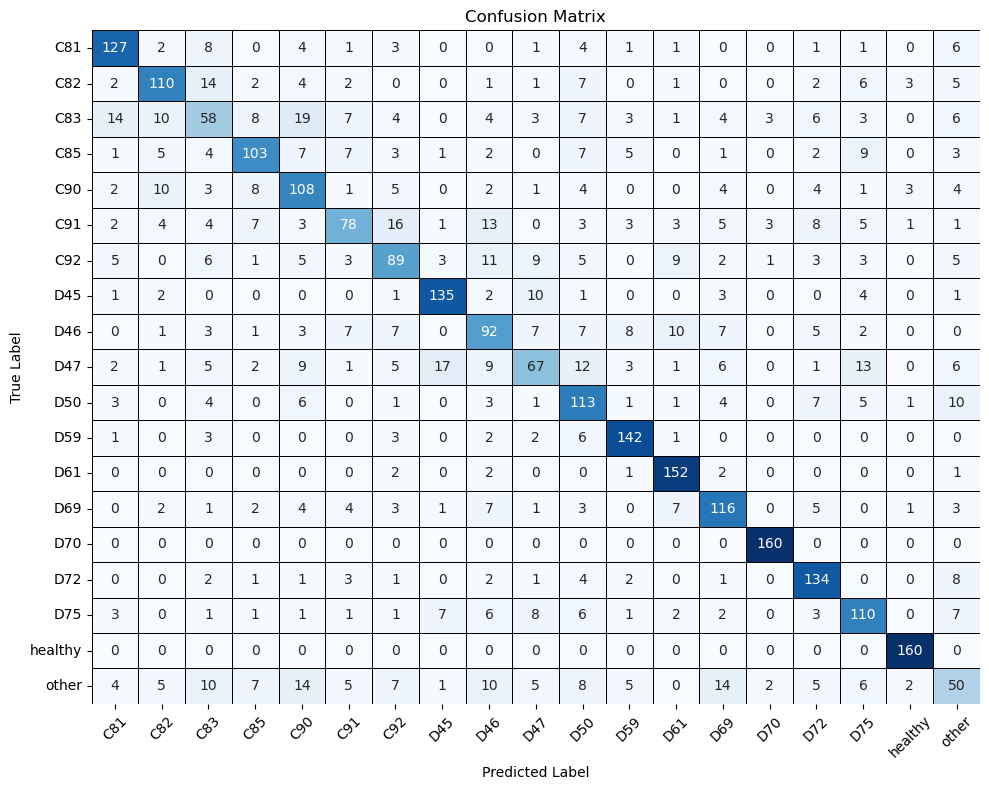

In [66]:
# conf_matrix
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_XBoost)

# Create a DataFrame for better visualization
conf_matrix_df = pd.DataFrame(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_df,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="black",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Testing for XGBoost

In [67]:
y_pred_XBoost_test = XBoost.predict(X_test)
y_proba_XBoost_test = (
    XBoost.predict_proba(X_test) if hasattr(XBoost, "predict_proba") else None
)

XBoost_best_model_test = {
    "Metric": [
        "Accuracy",
        "F1-micro",
        "F1-macro",
        "F1-weighted",
        "Precision",
        "Recall",
        "AUC-ROC",
    ],
    "Value": [
        accuracy_score(y_test, y_pred_XBoost_test),
        f1_score(y_test, y_pred_XBoost_test, average="micro"),
        f1_score(y_test, y_pred_XBoost_test, average="macro"),
        f1_score(y_test, y_pred_XBoost_test, average="weighted"),
        precision_score(y_test, y_pred_XBoost_test, average="macro"),
        recall_score(y_test, y_pred_XBoost_test, average="macro"),
        roc_auc_score(y_test, y_proba_XBoost_test, multi_class="ovr"),
    ],
}

# Convert validation results to DataFrame
boost_results_XGboost_test = pd.DataFrame(XBoost_best_model_test)
print("\n=== Validation Set Performance ===")
print(boost_results_XGboost_test)


=== Validation Set Performance ===
        Metric     Value
0     Accuracy  0.678684
1     F1-micro  0.678684
2     F1-macro  0.671063
3  F1-weighted  0.671063
4    Precision  0.668267
5       Recall  0.678684
6      AUC-ROC  0.950930


### Matrix Testing XGBoost

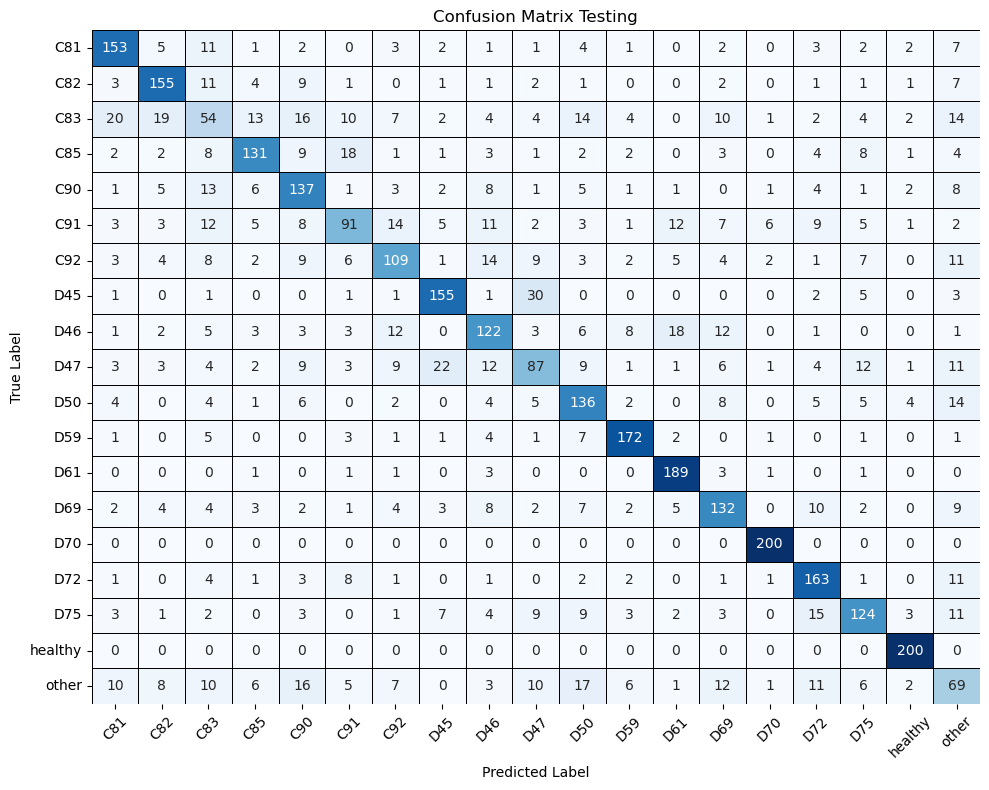

In [68]:
# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, y_pred_XBoost_test)

# Create a DataFrame for better visualization
conf_matrix_df_test = pd.DataFrame(conf_matrix_test)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="black",
    xticklabels=le.classes_,
    yticklabels=le.classes_,  # True labels
)
plt.title("Confusion Matrix Testing")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### SHAP - SHapley Additive exPlanations ( for XGBoost)

#### 🔍 Interpretability of Feature Importance
- Visualizes which features most strongly influence model predictions for each class
- **Heatmap intensity** → Feature contribution strength (darker = greater impact)

#### 🎯 Class-Specific Importance
Each column represents a disease class, revealing:
- **Critical diagnostic features** for specific diseases
- **Feature importance variation** across different classes

#### 🔬 Comparative Analysis Identifies:
| Feature Type        | Characteristics                          |
|---------------------|------------------------------------------|
| Universal features  | Important for all disease classes        |
| Specific markers    | Unique to individual diseases            |


<Figure size 3000x3000 with 0 Axes>

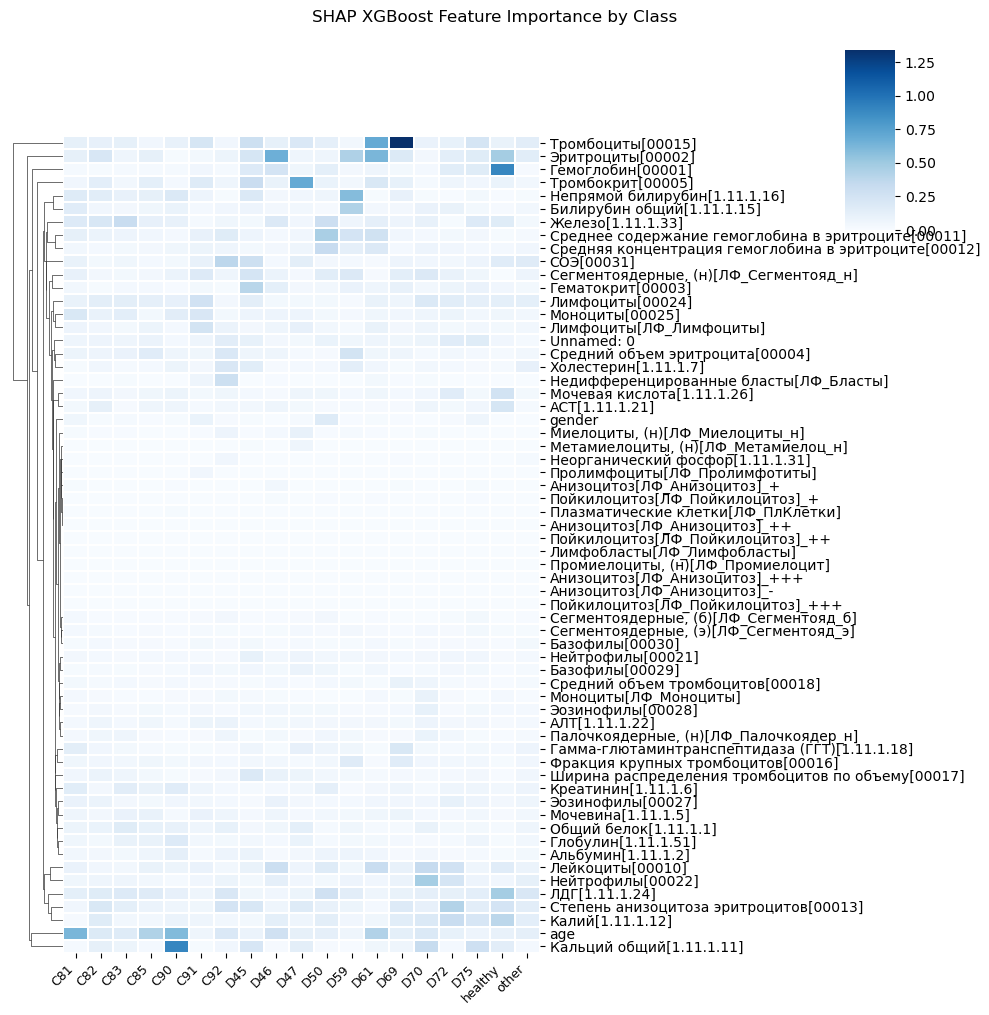

In [69]:
explainer = shap.TreeExplainer(XBoost)
shap_values_XBoost = explainer.shap_values(X_val)

# Create human-readable labels
class_names = le.inverse_transform(range(len(le.classes_)))
label_mapping = {i: name for i, name in enumerate(class_names)}

# for each class, calculate the mean absolute SHAP value for each featur
n_classes = shap_values_XBoost.shape[-1]
importance_per_class_df = pd.DataFrame(
    {
        f"{label_mapping[i]}": np.abs(shap_values_XBoost[:, :, i]).mean(axis=0)
        for i in range(n_classes)
    },
    index=X_balanced.columns,
)

importance_per_class_df = importance_per_class_df.sort_values(
    by=importance_per_class_df.columns[0], ascending=False
)


plt.figure(figsize=(30, 30))
g = sns.clustermap(
    importance_per_class_df,
    cmap="Blues",
    dendrogram_ratio=0.1,
    cbar_pos=(0.85, 0.8, 0.05, 0.18),
    col_cluster=False,
    row_cluster=True,
    yticklabels=True,
    linewidths=0.1,
)
plt.suptitle("SHAP XGBoost Feature Importance by Class", y=1.02)

g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=9
)

plt.show()

- Based on the results of the SHAP analysis, we can see that the model correctly uses features to determine the disease.

- For example, D69 - thrombocytopenia - and in the feature importance analysis, we see that the platelet feature has a strong influence.

###  Model saving

In [70]:
# XBoost.save_model('XGBoost.json')  # Save the model to a file

In [71]:
# import json

# metadata = {
#     'model_type': 'XGBoost',
#     'version': '1.0',
#     'hyperparameters': XBoost.get_params(),
# }

# with open('XBoost_metadata.json', 'w') as f:
#     json.dump(metadata, f, indent=4)

## 2. LightGBM (Light Gradient Boosting Machine)

#### Advantages:

- ✅ Very high speed – leaf-wise tree growth and memory optimization.
- ✅ Effective on large data sets – GOSS (gradient selection) and histogram-based binning.
- ✅ Works well with class imbalance – automatic weighting.

#### Disadvantages:

- ❌ Sensitive to overfitting – requires careful hyperparameter tuning.
- ❌ Partial support for categorical features – not as advanced as CatBoost.

## Optimization for LigthGBM 

In [72]:
def objective_LightGBM(trial) -> float:
    """Objective function for hyperparameter optimization using Optuna."""

    params = {
        # Core parameters
        "objective": "binary" if len(np.unique(y_train)) == 2 else "multiclass",
        "boosting_type": "gbdt",
        "random_state": 42,
        "verbosity": -1,
        "n_jobs": -1,
        # tree structure
        "num_leaves": trial.suggest_int("num_leaves", 31, 127),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 60),
        # parametrs
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
        "n_estimators": 500,
        "subsample": 0.8,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        # regularization
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 1.0),
    }

    # Multiclass handling
    if params["objective"] == "multiclass":
        params["num_class"] = len(np.unique(y_train))

    model = lgb.LGBMClassifier(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
    )

    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average="macro")


# Create study
study_lgb = optuna.create_study(direction="maximize")

# Optimize
study_lgb.optimize(objective_LightGBM, n_trials=30)

# Results
print("Best trial:")
trial = study_lgb.best_trial
print(f"  F1-score: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[175]	valid_0's multi_logloss: 1.08405
[176]	valid_0's multi_logloss: 1.08489
[177]	valid_0's multi_logloss: 1.085
[178]	valid_0's multi_logloss: 1.08562
[179]	valid_0's multi_logloss: 1.08636
[180]	valid_0's multi_logloss: 1.08702
[181]	valid_0's multi_logloss: 1.08758
[182]	valid_0's multi_logloss: 1.08796
[183]	valid_0's multi_logloss: 1.08883
[184]	valid_0's multi_logloss: 1.08924
[185]	valid_0's multi_logloss: 1.08945
[186]	valid_0's multi_logloss: 1.08999
[187]	valid_0's multi_logloss: 1.09019
[188]	valid_0's multi_logloss: 1.09072
[189]	valid_0's multi_logloss: 1.09134
[190]	valid_0's multi_logloss: 1.0918
[191]	valid_0's multi_logloss: 1.09252
[192]	valid_0's multi_logloss: 1.093
[193]	valid_0's multi_logloss: 1.09397
[194]	valid_0's multi_logloss: 1.09443
[195]	valid_0's multi_logloss: 1.09518
[196]	valid_0's multi_logloss: 1.09551
[197]	valid_0's multi_logloss: 1.09615
[198]	valid_0's multi_logloss: 1.09692
[199]	valid_0's multi_logloss: 1.09715
[200]	valid_0's multi_logloss:

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-08-10 15:00:47,030] Trial 23 finished with value: 0.6854014254421658 and parameters: {'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 25, 'learning_rate': 0.08276907677489063, 'colsample_bytree': 0.7448537704982247, 'reg_alpha': 0.2392964423118326, 'reg_lambda': 0.7156706063473773}. Best is trial 11 with value: 0.6864768199680034.
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1]	valid_0's multi_logloss: 2.68611
[2]	valid_0's multi_logloss: 2.52578
[3]	valid_0's multi_logloss: 2.40664
[4]	valid_0's multi_logloss: 2.30742
[5]	valid_0's multi_logloss: 2.22657
[6]	valid_0's multi_logloss: 2.1528
[7]	valid_0's multi_logloss: 2.09134
[8]	valid_0's multi_logloss: 2.03285
[9]	valid_0's multi_logloss: 1.98126
[10]	valid_0's multi_logloss: 1.9357
[11]	valid_0's multi_logloss: 1.89148
[12]	valid_0's multi_logloss: 1.85179
[13]	valid_0's multi_logloss: 1.81508
[14]	valid_0's multi_logloss: 1.78057
[15]	valid_0's multi_logloss: 1.75005
[16]	valid_0's multi_logloss: 1.72388
[17]	valid_0's multi_logloss: 1.69768
[18]	valid_0's multi_logloss: 1.67366
[19]	valid_0's multi_logloss: 1.65041
[20]	valid_0's multi_logloss: 1.62849
[21]	valid_0's multi_logloss: 1.60746
[22]	valid_0's multi_logloss: 1.58794
[23]	valid_0's multi_logloss: 1.56906
[24]	valid_0's multi_logloss: 1.55177
[25]	valid_0's multi_logloss: 1.5352
[26]	valid_0's multi_logloss: 1.51872
[27]	valid_0's multi_log

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-08-10 15:01:03,134] Trial 24 finished with value: 0.6814517359662219 and parameters: {'num_leaves': 54, 'max_depth': 6, 'min_child_samples': 22, 'learning_rate': 0.06150260516586945, 'colsample_bytree': 0.7883521024484744, 'reg_alpha': 0.4604003066950718, 'reg_lambda': 0.6382558549195724}. Best is trial 11 with value: 0.6864768199680034.
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1]	valid_0's multi_logloss: 2.39695
[2]	valid_0's multi_logloss: 2.17261
[3]	valid_0's multi_logloss: 2.01765
[4]	valid_0's multi_logloss: 1.89127
[5]	valid_0's multi_logloss: 1.79306
[6]	valid_0's multi_logloss: 1.70969
[7]	valid_0's multi_logloss: 1.63989
[8]	valid_0's multi_logloss: 1.58193
[9]	valid_0's multi_logloss: 1.5332
[10]	valid_0's multi_logloss: 1.48928
[11]	valid_0's multi_logloss: 1.45161
[12]	valid_0's multi_logloss: 1.41945
[13]	valid_0's multi_logloss: 1.39034
[14]	valid_0's multi_logloss: 1.36453
[15]	valid_0's multi_logloss: 1.33853
[16]	valid_0's multi_logloss: 1.3173
[17]	valid_0's multi_logloss: 1.29687
[18]	valid_0's multi_logloss: 1.27874
[19]	valid_0's multi_logloss: 1.26246
[20]	valid_0's multi_logloss: 1.24794
[21]	valid_0's multi_logloss: 1.23536
[22]	valid_0's multi_logloss: 1.22344
[23]	valid_0's multi_logloss: 1.21358
[24]	valid_0's multi_logloss: 1.20259
[25]	valid_0's multi_logloss: 1.19278
[26]	valid_0's multi_logloss: 1.18448
[27]	valid_0's multi_lo

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-08-10 15:01:13,815] Trial 25 finished with value: 0.67429693509899 and parameters: {'num_leaves': 87, 'max_depth': 8, 'min_child_samples': 29, 'learning_rate': 0.13859242543468608, 'colsample_bytree': 0.839616575983309, 'reg_alpha': 0.3606522717280725, 'reg_lambda': 0.9161095691314651}. Best is trial 11 with value: 0.6864768199680034.
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1]	valid_0's multi_logloss: 2.53893
[2]	valid_0's multi_logloss: 2.33642
[3]	valid_0's multi_logloss: 2.19514
[4]	valid_0's multi_logloss: 2.08092
[5]	valid_0's multi_logloss: 1.98507
[6]	valid_0's multi_logloss: 1.89961
[7]	valid_0's multi_logloss: 1.8301
[8]	valid_0's multi_logloss: 1.76974
[9]	valid_0's multi_logloss: 1.715
[10]	valid_0's multi_logloss: 1.668
[11]	valid_0's multi_logloss: 1.62658
[12]	valid_0's multi_logloss: 1.58841
[13]	valid_0's multi_logloss: 1.55498
[14]	valid_0's multi_logloss: 1.52087
[15]	valid_0's multi_logloss: 1.49338
[16]	valid_0's multi_logloss: 1.47033
[17]	valid_0's multi_logloss: 1.44894
[18]	valid_0's multi_logloss: 1.42651
[19]	valid_0's multi_logloss: 1.40522
[20]	valid_0's multi_logloss: 1.38782
[21]	valid_0's multi_logloss: 1.37112
[22]	valid_0's multi_logloss: 1.35389
[23]	valid_0's multi_logloss: 1.33934
[24]	valid_0's multi_logloss: 1.32728
[25]	valid_0's multi_logloss: 1.31351
[26]	valid_0's multi_logloss: 1.30354
[27]	valid_0's multi_loglo

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-08-10 15:01:29,314] Trial 26 finished with value: 0.6849027896320655 and parameters: {'num_leaves': 73, 'max_depth': 7, 'min_child_samples': 42, 'learning_rate': 0.10097728368562958, 'colsample_bytree': 0.7417959910649927, 'reg_alpha': 0.10246616912292446, 'reg_lambda': 0.7854207455238464}. Best is trial 11 with value: 0.6864768199680034.
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1]	valid_0's multi_logloss: 2.63336
[2]	valid_0's multi_logloss: 2.45663
[3]	valid_0's multi_logloss: 2.32851
[4]	valid_0's multi_logloss: 2.22235
[5]	valid_0's multi_logloss: 2.13498
[6]	valid_0's multi_logloss: 2.05794
[7]	valid_0's multi_logloss: 1.99129
[8]	valid_0's multi_logloss: 1.93183
[9]	valid_0's multi_logloss: 1.88063
[10]	valid_0's multi_logloss: 1.83364
[11]	valid_0's multi_logloss: 1.79225
[12]	valid_0's multi_logloss: 1.75428
[13]	valid_0's multi_logloss: 1.72017
[14]	valid_0's multi_logloss: 1.68834
[15]	valid_0's multi_logloss: 1.66026
[16]	valid_0's multi_logloss: 1.63376
[17]	valid_0's multi_logloss: 1.60829
[18]	valid_0's multi_logloss: 1.58611
[19]	valid_0's multi_logloss: 1.56421
[20]	valid_0's multi_logloss: 1.54278
[21]	valid_0's multi_logloss: 1.52323
[22]	valid_0's multi_logloss: 1.50428
[23]	valid_0's multi_logloss: 1.48913
[24]	valid_0's multi_logloss: 1.4744
[25]	valid_0's multi_logloss: 1.45942
[26]	valid_0's multi_logloss: 1.44668
[27]	valid_0's multi_l

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-08-10 15:01:45,940] Trial 27 finished with value: 0.6782612846432858 and parameters: {'num_leaves': 119, 'max_depth': 6, 'min_child_samples': 48, 'learning_rate': 0.0783156646931147, 'colsample_bytree': 0.8876562411525106, 'reg_alpha': 0.15968334556806815, 'reg_lambda': 0.5736582754490829}. Best is trial 11 with value: 0.6864768199680034.
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1]	valid_0's multi_logloss: 2.68371
[2]	valid_0's multi_logloss: 2.51283
[3]	valid_0's multi_logloss: 2.38838
[4]	valid_0's multi_logloss: 2.28322
[5]	valid_0's multi_logloss: 2.19532
[6]	valid_0's multi_logloss: 2.11582
[7]	valid_0's multi_logloss: 2.04764
[8]	valid_0's multi_logloss: 1.98567
[9]	valid_0's multi_logloss: 1.92745
[10]	valid_0's multi_logloss: 1.87594
[11]	valid_0's multi_logloss: 1.83024
[12]	valid_0's multi_logloss: 1.78707
[13]	valid_0's multi_logloss: 1.74793
[14]	valid_0's multi_logloss: 1.71295
[15]	valid_0's multi_logloss: 1.68077
[16]	valid_0's multi_logloss: 1.65101
[17]	valid_0's multi_logloss: 1.62245
[18]	valid_0's multi_logloss: 1.59555
[19]	valid_0's multi_logloss: 1.57052
[20]	valid_0's multi_logloss: 1.54824
[21]	valid_0's multi_logloss: 1.5263
[22]	valid_0's multi_logloss: 1.50516
[23]	valid_0's multi_logloss: 1.48623
[24]	valid_0's multi_logloss: 1.4677
[25]	valid_0's multi_logloss: 1.45009
[26]	valid_0's multi_logloss: 1.43437
[27]	valid_0's multi_lo

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-08-10 15:02:00,974] Trial 28 finished with value: 0.6823214360634565 and parameters: {'num_leaves': 75, 'max_depth': 8, 'min_child_samples': 35, 'learning_rate': 0.06045765650062611, 'colsample_bytree': 0.7529111466876308, 'reg_alpha': 0.5607129105062006, 'reg_lambda': 0.7595650518437559}. Best is trial 11 with value: 0.6864768199680034.
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[1]	valid_0's multi_logloss: 2.63077
[2]	valid_0's multi_logloss: 2.47853
[3]	valid_0's multi_logloss: 2.36321
[4]	valid_0's multi_logloss: 2.27308
[5]	valid_0's multi_logloss: 2.20101
[6]	valid_0's multi_logloss: 2.14204
[7]	valid_0's multi_logloss: 2.09048
[8]	valid_0's multi_logloss: 2.04332
[9]	valid_0's multi_logloss: 2.00102
[10]	valid_0's multi_logloss: 1.96495
[11]	valid_0's multi_logloss: 1.93341
[12]	valid_0's multi_logloss: 1.90552
[13]	valid_0's multi_logloss: 1.87886
[14]	valid_0's multi_logloss: 1.85283
[15]	valid_0's multi_logloss: 1.83004
[16]	valid_0's multi_logloss: 1.81047
[17]	valid_0's multi_logloss: 1.78993
[18]	valid_0's multi_logloss: 1.7738
[19]	valid_0's multi_logloss: 1.75758
[20]	valid_0's multi_logloss: 1.74249
[21]	valid_0's multi_logloss: 1.72785
[22]	valid_0's multi_logloss: 1.71482
[23]	valid_0's multi_logloss: 1.7015
[24]	valid_0's multi_logloss: 1.69
[25]	valid_0's multi_logloss: 1.6792
[26]	valid_0's multi_logloss: 1.66751
[27]	valid_0's multi_loglos

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-08-10 15:02:07,036] Trial 29 finished with value: 0.6726275427019491 and parameters: {'num_leaves': 35, 'max_depth': 3, 'min_child_samples': 20, 'learning_rate': 0.11161198038131132, 'colsample_bytree': 0.7272712678121196, 'reg_alpha': 0.07559861333440746, 'reg_lambda': 0.40879896066235233}. Best is trial 11 with value: 0.6864768199680034.


Best trial:
  F1-score: 0.6865
  Params:
    num_leaves: 102
    max_depth: 5
    min_child_samples: 46
    learning_rate: 0.05355757835144205
    colsample_bytree: 0.7024796879305022
    reg_alpha: 0.033404774302462054
    reg_lambda: 0.9849952705632951


### 🏆 Best Hyperparameters Trial for LigthGBM

| Metric            | Value                  |
|-------------------|------------------------|
| **Best F1-Score** | `0.6914`              |

### ⚙️ Optimized Parameters

| Parameter           | Optimal Value         |
|---------------------|----------------------|
| `num_leaves`      | 59                  |
| `max_depth`     | 7               |
| `min_child_samples`         | 39                    |
| `learning_rate`         | 0.068             |
| `colsample_bytree`  | 0.925             |
| `reg_alpha`             | 0.00573             |
| `reg_lambda`         | 0.768            |


### Training with best_params (LigthGBM)

In [73]:
best_params_lgb = study_lgb.best_params


LigthGBM_best_model = {}

# Model Training with best parameters
LigthGBM = lgb.LGBMClassifier(**best_params_lgb)
LigthGBM.fit(np.array(X_train), np.array(y_train))
y_pred_LigthGBM = LigthGBM.predict(X_val)
y_proba_LigthGBM = (
    LigthGBM.predict_proba(X_val) if hasattr(LigthGBM, "predict_proba") else None
)

LigthGBM_best_model = {
    "Metric": [
        "Accuracy",
        "F1-micro",
        "F1-macro",
        "F1-weighted",
        "Precision",
        "Recall",
    ],
    "Value": [
        accuracy_score(y_val, y_pred_LigthGBM),
        f1_score(y_val, y_pred_LigthGBM, average="micro"),
        f1_score(y_val, y_pred_LigthGBM, average="macro"),
        f1_score(y_val, y_pred_LigthGBM, average="weighted"),
        precision_score(y_val, y_pred_LigthGBM, average="macro"),
        recall_score(y_val, y_pred_LigthGBM, average="macro"),
    ],
}

# Convert validation results to DataFrame
boost_results_LigthGBM = pd.DataFrame(LigthGBM_best_model)
print("\n=== Validation Set Performance ===")
print(boost_results_LigthGBM)

/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== Validation Set Performance ===
        Metric     Value
0     Accuracy  0.630263
1     F1-micro  0.630263
2     F1-macro  0.619612
3  F1-weighted  0.619612
4    Precision  0.619038
5       Recall  0.630263


/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Compare with XGBoost (Validation)

In [74]:
print(f"LigthGBM", boost_results_LigthGBM, sep="\n")
print("\n=========================")

print(f"XGBoost", boost_results_XGboost, sep="\n")

LigthGBM
        Metric     Value
0     Accuracy  0.630263
1     F1-micro  0.630263
2     F1-macro  0.619612
3  F1-weighted  0.619612
4    Precision  0.619038
5       Recall  0.630263

XGBoost
        Metric     Value
0     Accuracy  0.692105
1     F1-micro  0.692105
2     F1-macro  0.683699
3  F1-weighted  0.683699
4    Precision  0.682549
5       Recall  0.692105
6      AUC-ROC  0.950658


### Confusion Matrix for LigthGBM

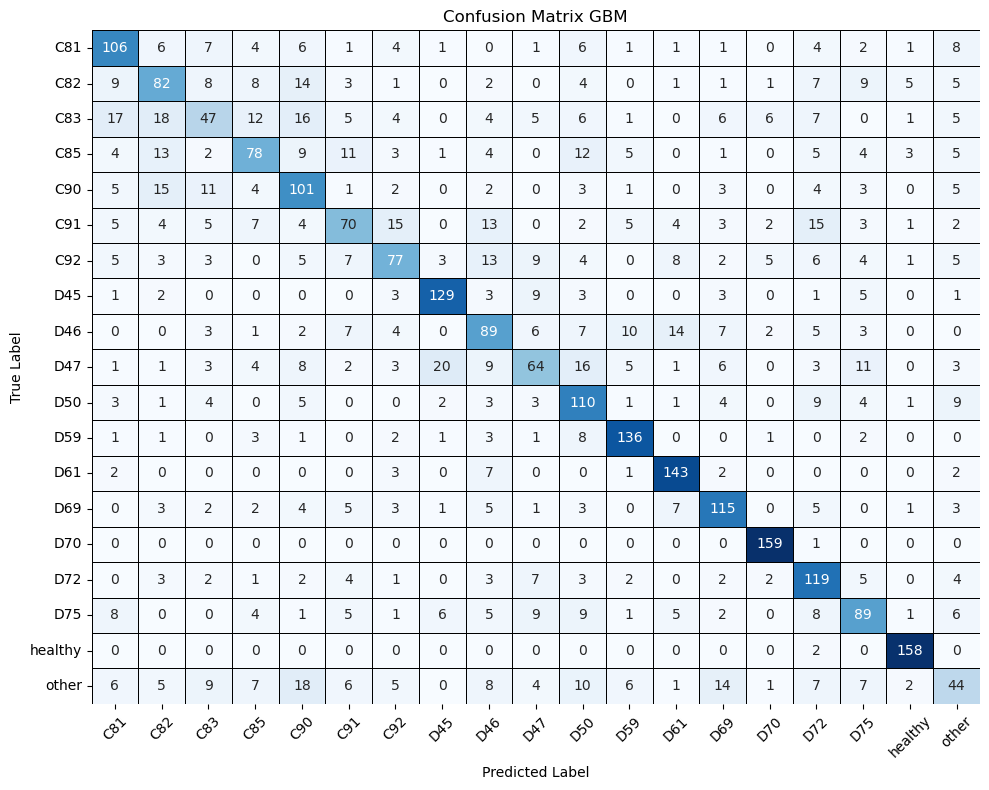

In [75]:
# Calculate confusion matrix
conf_matrix_gbm = confusion_matrix(y_val, y_pred_LigthGBM)

# Create a DataFrame for better visualization
conf_matrix_df_gbm = pd.DataFrame(conf_matrix_gbm)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_df_gbm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="black",
    xticklabels=le.classes_,
    yticklabels=le.classes_,
)
plt.title("Confusion Matrix GBM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

###  Testing for LigthGBM

In [76]:
y_pred_LigthGBM_test = LigthGBM.predict(X_test)

LigthGBM_best_model_test = {
    "Metric": [
        "Accuracy",
        "F1-micro",
        "F1-macro",
        "F1-weighted",
        "Precision",
        "Recall",
    ],
    "Value": [
        accuracy_score(y_test, y_pred_LigthGBM_test),
        f1_score(y_test, y_pred_LigthGBM_test, average="micro"),
        f1_score(y_test, y_pred_LigthGBM_test, average="macro"),
        f1_score(y_test, y_pred_LigthGBM_test, average="weighted"),
        precision_score(y_test, y_pred_LigthGBM_test, average="macro"),
        recall_score(y_test, y_pred_LigthGBM_test, average="macro"),
    ],
}

# Convert validation results to DataFrame
boost_results_LigthGBM_test = pd.DataFrame(LigthGBM_best_model_test)
print("\n=== Validation Set Performance ===")
print(boost_results_LigthGBM_test)


=== Validation Set Performance ===
        Metric     Value
0     Accuracy  0.631842
1     F1-micro  0.631842
2     F1-macro  0.621459
3  F1-weighted  0.621459
4    Precision  0.620270
5       Recall  0.631842


/Users/valeria/miniconda3/envs/bioINF/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


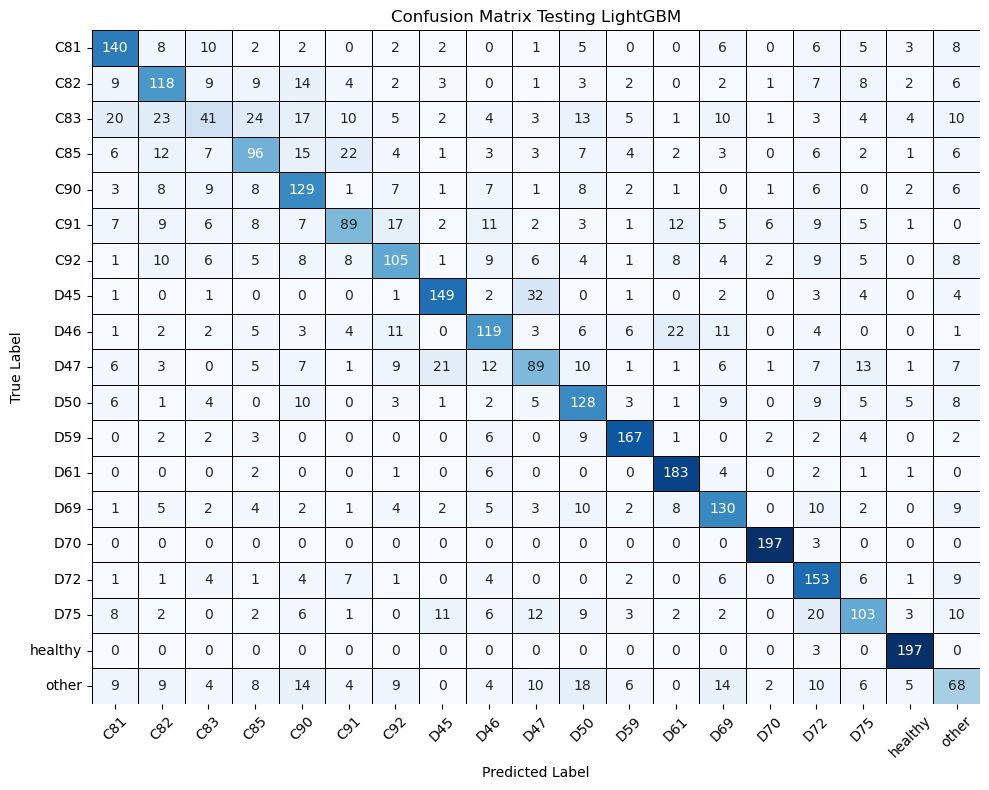

In [77]:
# Calculate confusion matrix
conf_matrix_gbm_test = confusion_matrix(y_test, y_pred_LigthGBM_test)

# Create a DataFrame for better visualization
conf_matrix_gbm_df_test = pd.DataFrame(conf_matrix_gbm_test)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_gbm_df_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="black",
    xticklabels=le.classes_,
    yticklabels=le.classes_,  # True labels
)
plt.title("Confusion Matrix Testing LightGBM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## SHAP (LightGBM)

<Figure size 3000x3000 with 0 Axes>

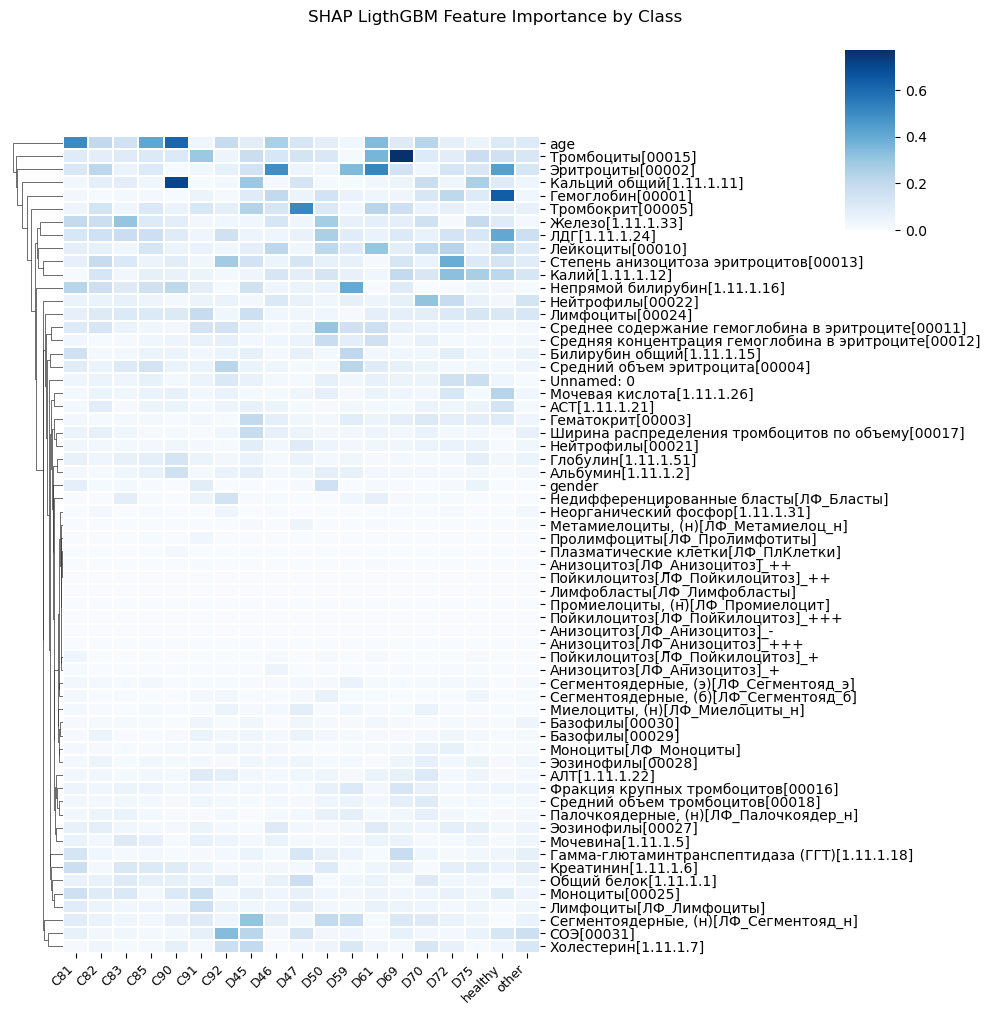

In [78]:
explainer_gbm = shap.TreeExplainer(LigthGBM)
shap_values_LightGBM = explainer_gbm.shap_values(X_val)


# for each class, calculate the mean absolute SHAP value for each featur
n_classes = shap_values_LightGBM.shape[-1]
importance_per_class_df_gbm = pd.DataFrame(
    {
        f"{label_mapping[i]}": np.abs(shap_values_LightGBM[:, :, i]).mean(axis=0)
        for i in range(n_classes)
    },
    index=X_balanced.columns,
)

importance_per_class_df_gbm = importance_per_class_df_gbm.sort_values(
    by=importance_per_class_df_gbm.columns[0], ascending=False
)


plt.figure(figsize=(30, 30))
g = sns.clustermap(
    importance_per_class_df_gbm,
    cmap="Blues",
    dendrogram_ratio=0.1,
    cbar_pos=(0.85, 0.8, 0.05, 0.18),
    col_cluster=False,
    row_cluster=True,
    yticklabels=True,
    linewidths=0.1,
)
plt.suptitle("SHAP LigthGBM Feature Importance by Class", y=1.02)

g.ax_heatmap.set_xticklabels(
    g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", fontsize=9
)

plt.show()

In [79]:
LigthGBM.booster_.save_model("LigthGBM.json")  # Save the model to a file

## Compare Test with XGBoost

In [80]:
print(f"LigthGBM", boost_results_LigthGBM_test, sep="\n")
print("\n=========================")

print(f"XGBoost", boost_results_XGboost_test, sep="\n")

LigthGBM
        Metric     Value
0     Accuracy  0.631842
1     F1-micro  0.631842
2     F1-macro  0.621459
3  F1-weighted  0.621459
4    Precision  0.620270
5       Recall  0.631842

XGBoost
        Metric     Value
0     Accuracy  0.678684
1     F1-micro  0.678684
2     F1-macro  0.671063
3  F1-weighted  0.671063
4    Precision  0.668267
5       Recall  0.678684
6      AUC-ROC  0.950930


# Analysis of Native-Support Models

**All models showed similar metrics. However, in another JupiterNotebook, we built a model based on **CatBoost**, which showed slightly higher metrics**

(Accuracy Test: 0.68)

### For the task of classifying disease families:

**LightGBM**
    
    - optimal when computational resources are limited

**CatBoost**
   
    - preferable when mixed (numerical + categorical) data is available

**XGBoost**
    
    - the best choice when maximum interpretability is required

## CatBoost showed the best results

### Automatic category processing
In medical data, CatBoost encodes diseases optimally without manual preprocessing.

## 🏆 Advantages
- #### Resistance to noise and omissions
- #### CatBoost copes better with outliers thanks to ordered boosting.
- #### Better generalization ability
- #### Less prone to overfitting on rare diagnoses due to advanced regularization.


## Why Native-Support Model showed the best results

**Built-in handling of missing values**:
   - XGBoost/LightGBM/CatBoost automatically treat NaN as a separate value
   - The optimal strategy is determined during training
